In [1]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

Connect to the SQL Lite Database

In [2]:
path = r'sqlite:///C:\'  #Insert path here
database = path + 'database.sqlite'

In [3]:
#create engine
engine = create_engine(database)
#connect to engine
con = engine.connect()

In [4]:
#view tables in database
pd.DataFrame(engine.table_names(), columns=['Table'])

,Table
0,Country
1,League
2,Match
3,Player
4,Player_Attributes
5,Team
6,Team_Attributes
7,sqlite_sequence


Teams, Matches, Leagues, and Countries

In [5]:
#merge match, league, country, and teams
match = pd.read_sql_query("""SELECT League.id,
                                    League.country_id,
                                    League.name as league,
                                    Country.name as country,
                                    Match.league_id,
                                    Match.season,
                                    Match.stage,
                                    Match.date,
                                    Match.match_api_id,
                                    Match.home_team_api_id,
                                    t1.team_long_name as home_team,
                                    Match.home_team_goal,
                                    Match.away_team_api_id,
                                    t2.team_long_name as away_team,
                                    Match.away_team_goal,
                                    (Match.home_team_goal + Match.away_team_goal) as goals_scored
                                    FROM Match 
                                    LEFT JOIN League ON Match.country_id = League.country_id
                                    LEFT JOIN Country ON Match.country_id = Country.id
                                    LEFT JOIN Team as t1 ON Match.home_team_api_id = t1.team_api_id
                                    LEFT JOIN Team as t2 ON Match.away_team_api_id = t2.team_api_id""", engine)
# #Convert date to date/time
match['date'] = [pd.to_datetime(match['date'][i]).date() for i in range(len(match))]
# #Create year variable
match['year'] = [match['date'][i].year for i in range(len(match))]
match.head(2)

,id,country_id,league,country,league_id,season,stage,date,match_api_id,home_team_api_id,home_team,home_team_goal,away_team_api_id,away_team,away_team_goal,goals_scored,year
0,1,1,Belgium Jupiler League,Belgium,1,2008/2009,1,2008-08-17,492473,9987,KRC Genk,1,9993,Beerschot AC,1,2,2008
1,1,1,Belgium Jupiler League,Belgium,1,2008/2009,1,2008-08-16,492474,10000,SV Zulte-Waregem,0,9994,Sporting Lokeren,0,0,2008


Player Attributes

In [6]:
player_attributes = pd.read_sql_query("""SELECT * FROM Player_Attributes""", engine)
player_attributes['year'] = [pd.to_datetime(player_attributes['date'][i]).year for i in range(len(player_attributes))]
player_attributes.head(2)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,year
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,2016
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,2015


Players

In [7]:
players = pd.read_sql_query("""SELECT * FROM Player""", engine)
players['birthday'] = [pd.to_datetime(players['birthday'][i]).date() for i in range(len(players))]
players.head(2)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146


Team Attributes

In [8]:
team_attributes = pd.read_sql_query("""SELECT * FROM Team_Attributes""", engine)
#Fill missing with mean
team_attributes['buildUpPlayDribbling'] = team_attributes['buildUpPlayDribbling'].fillna(team_attributes['buildUpPlayDribbling'].mean())
#year variable
team_attributes['year'] = [pd.to_datetime(team_attributes['date'][i]).year for i in range(len(team_attributes))]
team_attributes.head(2)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,year
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,48.607362,Little,50,Mixed,...,Normal,Organised,50,Medium,55,Press,45,Normal,Cover,2010
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.000000,Normal,56,Mixed,...,Normal,Organised,47,Medium,44,Press,54,Normal,Cover,2014


In [9]:
#Calculate Number of Teams
number_of_teams = match[['league', 'season', 'home_team_api_id']].drop_duplicates().groupby(['league', 'season'], as_index = False).count().rename(columns={'home_team_api_id':'number_of_teams'})
number_of_teams['games_played'] = [number_of_teams['number_of_teams'][i]*2 for i in range(len(number_of_teams))]

Close our database connection.

In [10]:
con.close()

### Leagues

Let's look at the average goals scored per game in leagues throughout the world

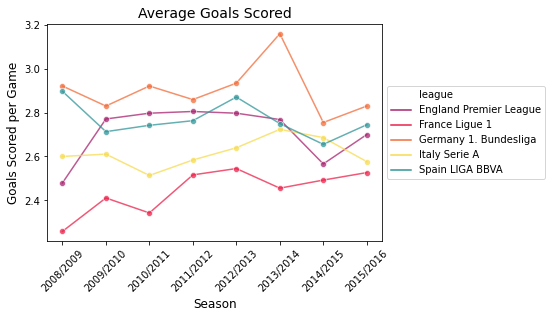

In [11]:
#set the palette
palette1 = ['#A7226E', '#EC2049', '#F26B38', '#F7DB4F', '#2F9599']
sns.set_palette(palette1)

#calculate the average goals scored by league per season
league_avg = match[['league', 'season', 'home_team_goal', 'away_team_goal', 'goals_scored']].groupby(['league', 'season'],
                                                                                                     as_index = False).mean()

#merge goals scored and games played into the data
league_avg = pd.merge(league_avg, number_of_teams, how='left', on=['league', 'season'])

#lets only look at the so called top 5 leagues around the world
top_leagues = ['England Premier League',
              'France Ligue 1',
              'Germany 1. Bundesliga',
              'Italy Serie A',
              'Spain LIGA BBVA']

#create a subset of the leagues we specify above
top5_avg = league_avg[league_avg['league'].isin(top_leagues)]

#plot the data
sns.lineplot(x='season', y='goals_scored', data=top5_avg, hue='league', marker='o', alpha=0.75)
plt.xticks(rotation=45, size=10)
plt.yticks(size=10)
plt.title('Average Goals Scored', size=14)
plt.ylabel('Goals Scored per Game', size=12)
plt.xlabel('Season', size=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Cotrary to popular belief, the German Bundesliga has the highest average goals scored per game. Next lets look at total goals scored in a season

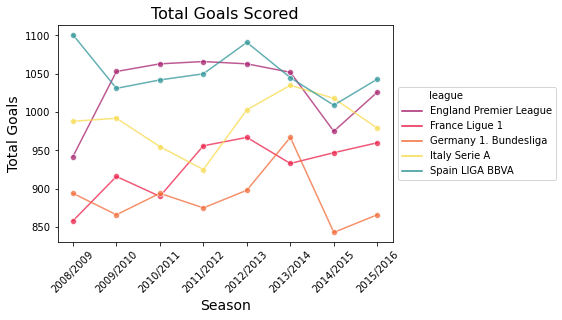

In [12]:
#calculate the total goals scored by league per season
league_totals = match[['league', 'season', 'home_team_goal', 'away_team_goal', 'goals_scored']].groupby(['league', 'season'],
                                                                                                        as_index = False).sum()

#merge number of teams and total games played into the data
league_totals = pd.merge(league_totals, number_of_teams, how='left', on=['league', 'season'])

#use the top 5 leagues from above
top5_tot = league_totals[league_totals['league'].isin(top_leagues)]

#plot the totals
sns.lineplot(x='season', y='goals_scored', data=top5_tot, hue='league', marker='o', alpha=0.75)
plt.xticks(rotation=45, size=10)
plt.yticks(size=10)
plt.title('Total Goals Scored', size=16)
plt.ylabel('Total Goals', size=14)
plt.xlabel('Season', size=14)
j = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

We now can see that although the Bundesliga has the highest average goals per game, it is among the lowest in terms of totals goals.

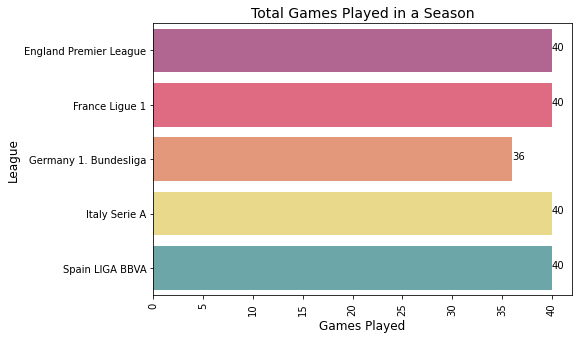

In [13]:
#plot the number of games played by these leagues
fig, ax = plt.subplots(figsize=(7.5,5))
sns.barplot(x='games_played', y='league', data=top5_avg, alpha=0.75)
plt.xticks(rotation=90, size=10)
plt.yticks(size=10)
ax.set_title('Total Games Played in a Season', size=14)
ax.set_ylabel('League', size=12)
ax.set_xlabel('Games Played', size=12)

y = top5_avg.sort_values('league')
y = top5_avg[['league', 'games_played']].drop_duplicates()
y = y.games_played.values

#Annotate bars
for i, v in enumerate(y):
    ax.text(v, i, str(v))

plt.show()

The Bundesliga played the least amount of games but was the highest scoring league in terms of goals per game.

### Players

In [14]:
#Average the scores of each player by year
attribute_avgs = player_attributes.groupby(['player_api_id', 'year'], as_index=False).mean().drop(['id', 'player_fifa_api_id'], axis = 1)

# Merge in the player name, height, weight, and birthdate
attribute_avgs = pd.merge(attribute_avgs, players, how='left', on='player_api_id')

#Create the player age variable
attribute_avgs['age'] = [attribute_avgs['year'][i] - attribute_avgs['birthday'][i].year for i in range(len(attribute_avgs))]
attribute_avgs['overall_rating'] = attribute_avgs['overall_rating'].round(0)

Let's narrow down and look at a few of the top players

In [15]:
#Choose Players of Interest
best_players = ['Cristiano Ronaldo', 'Lionel Messi', 'Zlatan Ibrahimovic', 'Neymar', 'Antoine Griezmann']
best = attribute_avgs[attribute_avgs['player_name'].isin(best_players)]

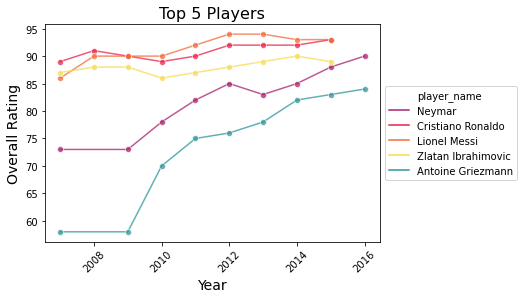

In [16]:
sns.lineplot(x='year', y='overall_rating', data=best, hue='player_name', marker='o', alpha=0.75)
plt.xticks(rotation=45, size=10)
plt.yticks(size=10)
plt.title('Top 5 Players', size=16)
plt.ylabel('Overall Rating', size=14)
plt.xlabel('Year', size=14)
j = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Griezmann and Neymar experienced significant growth over the 8 years of our data

### Draw a Football Pitch

In [17]:
def draw_pitch(pitch, line, orientation,view):
    
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)

        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)

### 2016 Champions League Final

Subset Real Madrid's starting XI

In [18]:
rm11 = ['Keylor Navas', 'Pepe', 'Sergio Ramos', 'Cristiano Ronaldo', 'Toni Kroos',
        'Karim Benzema', 'Gareth Bale', 'Marcelo', 'Casemiro', 'Daniel Carvajal', 'Luka Modric']

rm11 = attribute_avgs[(attribute_avgs['player_name'].isin(rm11)) & (attribute_avgs['year']==2015)]
rm11 = rm11.sort_values('overall_rating', ascending=False).drop_duplicates('player_name').reset_index(drop=True)

Subset Atletico Madrid's Starting XI

In [19]:
at11 = ['Jan Oblak', 'Juanfran', 'Stefan Savic', 'Diego Godin', 'Filipe Luis', 'Saul Niguez', 'Gabi',
        'Augusto Fernandez', 'Antoine Griezmann', 'Fernando Torres', 'Koke']

at11 = attribute_avgs[(attribute_avgs['player_name'].isin(at11)) & (attribute_avgs['year']==2015)]
at11 = at11.sort_values('overall_rating', ascending=False).drop_duplicates('player_name').reset_index(drop=True)

List of coordinants to position the players into the proper formations on our pitch

In [20]:
x = [3, 27, 25, 25, 27, 37, 33, 37, 47, 50, 47, 102, 83, 85, 85, 83, 63, 70, 70, 63, 58, 58]
y = [34, 60, 42, 22, 6, 50, 35, 20, 62, 34, 4, 34, 60, 45, 25, 6, 65, 45, 25, 5, 42, 26]

Match player to their position for Real Madrid.

In [21]:
rmpos = [9, 4, 8, 11, 10, 6, 3, 2, 5, 1, 7]
rm11 = rm11[['player_name', 'overall_rating']]
rm11['pos'] = rmpos
rm11 = rm11.sort_values('pos').reset_index(drop=True)
rm11['team'] = 'Real Madrid'
rm11['color'] = 'blue'

Match to position for Atletico.

In [22]:
atpos = [4, 11, 9, 5, 2, 1, 10, 7, 3, 8, 6]
at11 = at11[['player_name', 'overall_rating']]
at11['pos'] = atpos
at11 = at11.sort_values('pos').reset_index(drop=True)
at11['team'] = 'Atletico Madrid'
at11['color'] = 'red'

In [23]:
pd.concat([at11[['team', 'pos', 'player_name', 'overall_rating']], 
           rm11[['team', 'pos', 'player_name', 'overall_rating']]], axis = 1)

,team,pos,player_name,overall_rating,team,pos,player_name,overall_rating
0,Atletico Madrid,1,Jan Oblak,81.0,Real Madrid,1,Keylor Navas,80.0
1,Atletico Madrid,2,Juanfran,81.0,Real Madrid,2,Marcelo,83.0
2,Atletico Madrid,3,Stefan Savic,80.0,Real Madrid,3,Pepe,84.0
3,Atletico Madrid,4,Diego Godin,85.0,Real Madrid,4,Sergio Ramos,87.0
4,Atletico Madrid,5,Filipe Luis,82.0,Real Madrid,5,Daniel Carvajal,81.0
5,Atletico Madrid,6,Saul Niguez,76.0,Real Madrid,6,Toni Kroos,86.0
6,Atletico Madrid,7,Gabi,80.0,Real Madrid,7,Casemiro,76.0
7,Atletico Madrid,8,Augusto Fernandez,78.0,Real Madrid,8,Luka Modric,87.0
8,Atletico Madrid,9,Koke,83.0,Real Madrid,9,Cristiano Ronaldo,93.0
9,Atletico Madrid,10,Fernando Torres,80.0,Real Madrid,10,Karim Benzema,86.0


Let's plot the line-ups with player ratings for the 2016 Champions League Final

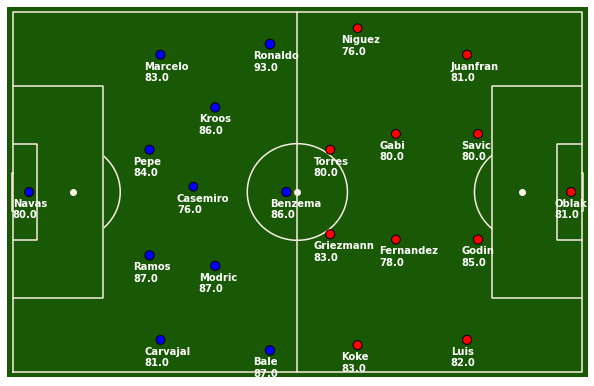

In [24]:
cl_final = rm11.append(at11).reset_index(drop=True)

cl_final['x'], cl_final['y'] = x, y

zo = 12
draw_pitch("#195905","#faf0e6","horizontal","full")
sns.set_palette(['navy', 'red'])
plt.scatter(cl_final['x'],cl_final['y'], marker='o', edgecolors='black', zorder=zo, s=cl_final['overall_rating'], c=cl_final['color'])
# j = plt.legend(['Real Madrid', 'Atletico Madrid'], 
#                loc='center left',
#                bbox_to_anchor=(1, 0.5))
players = cl_final['player_name'].drop_duplicates().to_list()
#Get last names
players = [players[i].split(' ')[len(players[i].split(' ')) - 1] for i in range(len(players))]
for i, txt in enumerate(cl_final['overall_rating']):
    #player name and rating to annotate
    plt.annotate('{}\n{}'.format(players[i], txt),
                 #x & y coordinates
                 (cl_final['x'][i] - 3, cl_final['y'][i] - 5),
                 #color
                 color='white',
                 #bold
                 fontweight='bold')

### Radar Plots

Define Function to Make Radar Plots

In [25]:
markers = [0, 20, 40, 60, 80, 100]
str_markers = ["0", "20", "40", "60", "80", "100"]

def make_radar_chart(name, stats, name2, stats2, attribute_labels, color='b', color2='r', plot_markers = markers, plot_str_markers = str_markers):

    labels = np.array(attribute_labels)

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats = np.concatenate((stats,[stats[0]]))
    stats2 = np.concatenate((stats2,[stats2[0]]))
    angles = np.concatenate((angles,[angles[0]]))

    fig = plt.figure()
    ax = fig.add_subplot(121, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2, c=color)
    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    plt.yticks(markers)
    ax.set_title(name)
    ax.grid(True)
    
    ax2 = fig.add_subplot(122, polar=True)
    ax2.plot(angles, stats2, 'o-', linewidth=2, c=color2)
    ax2.fill(angles, stats2, alpha=0.25)
    ax2.set_thetagrids(angles * 180/np.pi, labels)
    plt.yticks(markers)
    ax2.set_title(name2)
    ax2.grid(True)

    return plt.show()

Let's compare the most important attacking stats of Karim Benzema and Fernando Torres. The two starting center forwards of the Champions League final.

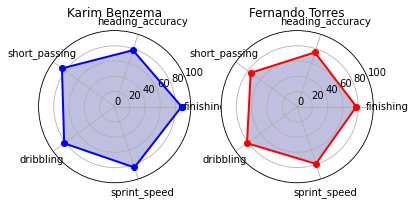

In [26]:
#Attacking stats
attk = ['finishing', 'heading_accuracy', 'short_passing', 'dribbling', 'sprint_speed']

#subset for our two players of interest
striker = ['Karim Benzema', 'Fernando Torres']
str1 = attribute_avgs[attk][(attribute_avgs['player_name']==striker[0]) & (attribute_avgs['year']==2015)]
str2 = attribute_avgs[attk][(attribute_avgs['player_name']==striker[1]) & (attribute_avgs['year']==2015)]

#create two radar plots to compare players
make_radar_chart(striker[0], str1.values[0].tolist(),
                 striker[1], str2.values[0].tolist(),
                 attribute_labels=attk)

While the two players look to have strikingly similar attacking prowess, Benzema appears to be better with his feet. He edges past Torres in both his finishing capability as well as short passing, two keys attributes for target forwards such as themselves.

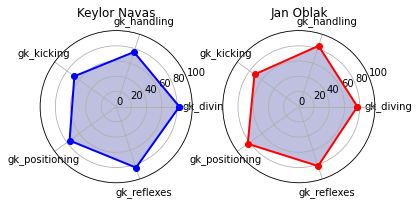

In [27]:
gk = ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']

#subset for our two players of interest
keeper = ['Keylor Navas', 'Jan Oblak']
player1 = attribute_avgs[gk][(attribute_avgs['player_name']==keeper[0]) & (attribute_avgs['year']==2015)]
player2 = attribute_avgs[gk][(attribute_avgs['player_name']==keeper[1]) & (attribute_avgs['year']==2015)]

#create two radar plots to compare players
make_radar_chart(keeper[0], player1.values[0].tolist(),
                 keeper[1], player2.values[0].tolist(),
                 attribute_labels=gk)

Oblak has the edge in kicking, positioning, and handling while Navas looks to be a better shotstopper with higher ratings in reflexes and diving.

### Cluster Players

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [29]:
#Calculate player stat averages
player_avgs = attribute_avgs.groupby(['player_name', 'player_api_id'], as_index = False).mean().drop(['year', 'id', 'player_fifa_api_id', 'player_api_id'], axis = 1)
player_avgs = player_avgs.dropna().reset_index(drop=True)

In [30]:
player = player_avgs[['player_name', 'height', 'weight', 'overall_rating', 'potential']]
player_avgs = player_avgs.drop(['player_name', 'height', 'weight', 'age', 'overall_rating', 'potential'], axis = 1).dropna()

In [31]:
vari = player_avgs.columns.tolist()

Since all player stats are on the same 0-100 scale we will not normalize the data before clustering, but below is the code we would use to scale.

In [32]:
#store code to normalize variables if needed
# scaler = MinMaxScaler()
# for var in vari:
#     player_avgs[var] = scaler.fit_transform(player_avgs[var].values.reshape(-1, 1))

In [33]:
ssd = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(player_avgs)
    ssd.append(km.inertia_)

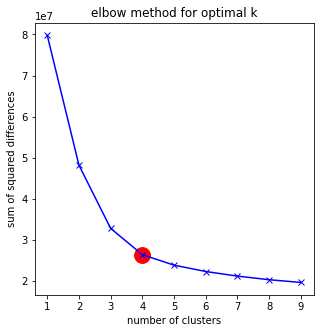

In [34]:
plt.figure(figsize=(5,5))
plt.plot(K, ssd, 'bx-')
#4 is the optimal number of clusters
plt.scatter(K[3], ssd[3], c='r', marker='o', s=250)
plt.title('elbow method for optimal k')
plt.xlabel('number of clusters')
plt.ylabel('sum of squared differences')
plt.show()

In [35]:
#4 is the optimal number of clusters

Cluster the players in our dataset using k=4 clusters.

In [36]:
kmeans = KMeans(n_clusters=4)
model = kmeans.fit(player_avgs)
pred = model.labels_
player_avgs['cluster'] = pred

Take a 3-D look at our clusters using Principal Component Analysis to do so.

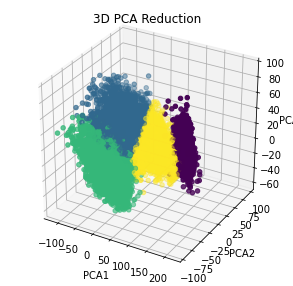

In [37]:
from mpl_toolkits import mplot3d
# Create PCA for data visualization / Dimensionality reduction to 3D graph
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_model = pca.fit_transform(player_avgs)
data_transform = pd.DataFrame(data = pca_model, columns = ['PCA1', 'PCA2', 'PCA3'])
data_transform['Cluster'] = pred

#plot the 3-D PCA
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.scatter3D(data_transform.PCA1, data_transform.PCA2, data_transform.PCA3, marker='o', c=data_transform.Cluster);
ax.set_title('3D PCA Reduction')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.show()

In [38]:
pca = PCA(n_components=2)
pca_model = pca.fit_transform(player_avgs)
data_transform = pd.DataFrame(pca_model, columns=['pca1', 'pca2'])
data_transform['cluster'] = pred

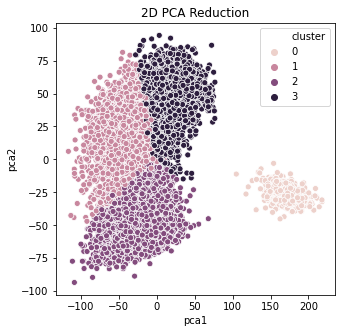

In [39]:
plt.figure(figsize=(5,5))
g = sns.scatterplot(data=data_transform, x='pca1', y='pca2', hue='cluster')
title = plt.title('2D PCA Reduction')

Mean attributes of our clusters.

In [40]:
#look at the mean attributes of our clusters
player_avgs.groupby('cluster').mean()

,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
cluster,,,,,,,,,,,,,,,,,,,,,
0,18.562216,17.809965,19.189217,27.712797,16.517040,18.678764,16.985357,17.836887,35.091861,23.774380,...,32.800859,30.044535,18.254648,18.942583,17.472473,67.688358,64.396139,62.635835,64.972527,69.075378
1,63.758287,51.309129,59.968181,69.829186,53.513663,64.227913,60.309108,57.403097,65.894893,68.925636,...,65.789916,59.444194,60.236449,64.544641,63.004462,9.656898,13.051212,25.872516,13.042826,13.049445
2,56.242964,63.986923,56.940201,62.023120,59.683383,67.287981,57.849289,52.359534,52.393551,67.251834,...,60.362422,60.612228,27.508240,30.674656,27.985559,9.756729,12.198424,17.963975,12.150330,12.126567
3,46.236333,31.792425,60.693196,56.779873,32.997405,46.409458,39.247605,37.615527,51.998823,55.229201,...,47.244788,44.719625,62.453069,65.132287,63.131466,9.831551,11.826326,16.855127,11.933226,11.814466


### Predict Player Rating

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [42]:
y = player.overall_rating
x = player_avgs

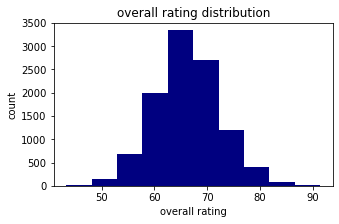

In [43]:
fig, ax = plt.subplots(figsize=(5,3))
plt.hist(y)
plt.xlabel('overall rating')
plt.ylabel('count')
plt.title('overall rating distribution')
plt.show()

The data looks normal. Let's plot the empirical distirbution to truly tell.

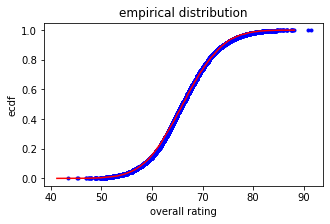

In [44]:
#ecdf for our data
xd = np.sort(y.values)
yd = np.arange(1, len(xd) + 1) / len(xd)

#theoretical normal distribution
nu = xd.mean()
sig = xd.std()
samples = np.random.normal(nu, sig, 10000)
x_theor = np.sort(samples)
y_theor = np.arange(1, len(samples) + 1) / len(samples)

fig, ax = plt.subplots(figsize=(5,3))
plt.plot(xd, yd, c='blue', linestyle='none', marker='.')
plt.plot(x_theor, y_theor, c='red')
plt.xlabel('overall rating')
plt.ylabel('ecdf')
plt.title('empirical distribution')
plt.show()

The empirical distribution shows us that our data follows a normal distribution.

### Linear Regression using PCA.

In [45]:
#set PCA to capture 95% of variation in our data
pca = PCA(.95)
pca.fit(x)
print('Number of components after PCA: {}'.format(pca.n_components_))

#transform the data
x = pca.transform(x)

#train, test, split
x_train, x_test, y_train, y_test = train_test_split(x, y.values, test_size=.3, random_state=123)

#fit our linear regression on training samples
reg = LinearRegression()
reg.fit(x_train, y_train)
# print('R-Square: {}'.format(reg.score(x_test, y_test).round(4)))


#use 10-fold cross validation to evaluate the model
rlin = cross_val_score(reg, x, y, cv=10).mean()
print('Linear Regression: {}'.format(rlin.round(4)))

Number of components after PCA: 15
Linear Regression: 0.7644


### Decision Tree Optimization

In [46]:
#reinitialize our x and y
y = player.overall_rating
x = player_avgs

Let's set up a grid search to determine optimal criterion and max depth.

In [47]:
#initialize tree model
tree = DecisionTreeRegressor()

# create lists of parameter for Decision Tree Regressor
criterion = ['mse', 'mae']
max_depth = [4, 6, 8, 10, 12, 14, 16]

#create a dictionary of all the parameter options
parameters = {'criterion':criterion,
             'max_depth':max_depth}

Use GridSearchCV to determine the optimal parameters of our data.

In [54]:
#grid search to find the best parameters
tree = GridSearchCV(tree, parameters)
tree.fit(x.values, y.values)
criteria = tree.best_estimator_.get_params()['criterion']
depth = tree.best_estimator_.get_params()['max_depth']
print('Best Criterion: {} | Max Depth: {}'.format(criteria, depth))

#train, test, split
x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size = 0.3, random_state=123)
#fit the model with optimal parameters
tree = DecisionTreeRegressor(criterion = criteria, max_depth = depth)
#fit the model using training samples
tree.fit(x_train, y_train)

#use 10-fold cross validation to determine score of the model
rtree = cross_val_score(tree, x.values, y.values, cv=10).mean()
print('Decision Tree: {}'.format(rtree.round(4)))

Best Criterion: mse | Max Depth: 12
Decision Tree: 0.8847


### Random Forest

In [48]:
rf = RandomForestRegressor(n_estimators=100, random_state=123)

In [49]:
rf.fit(x_train, y_train)
rf.score(x_test, y_test)

0.944094819597119

In [57]:
cross_val_score(rf, x.values, y.values, cv=10).mean()

0.9524418293611043

In [58]:
#number of estimators
# n_estimators = [100, 500, 1000]
# # Maximum number of levels in tree
# max_depth = [6, 8, 10, 12, 14]
# #define parameters
# parameters = {'n_estimators':n_estimators,
#              'max_depth':max_depth}

In [59]:
# rf = GridSearchCV(rf, parameters)
# rf.fit(x_train, y_train)
# rf.best_params_